# Predict the state-wide true case counts

This project uses the testing rates per state (from [https://covidtracking.com/](https://covidtracking.com/)), reported case counts by state and the reported mortality rates by state to **estimate the number of unreported (untested) COVID-19 cases in each U.S. state.**

The analysis makes a few assumptions:

1. The probability that a case is reported by a state is a function of the number of tests run per person in that state.  Hence the degree of under-reported cases is a function of tests run per capita.
2. The underlying mortality rate is the same across every state.
3. Patients take time to succumb to COVID-19, so the mortality counts *today* reflect the case counts *7 days ago*.  E.g., mortality rate = (cumulative deaths today) / (cumulative cases 7 days ago).

In all, the model attempts to find the most likely relationship between state-wise test volume (per capita) and under-reporting, such that the true underlying mortality rates between the individual states are as similar as possible.  The model simultaneously finds the most likely posterior distribution of mortality rates, the most likely *true* case count per state, and the test volume vs. case underreporting relationship.

Please see the source code in [source](source).

In [1]:
# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from source import data, model

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = data.get_statewise_testing_data()

Dropping 4/56 states due to lack of population data
Dropping 11/52 states due to lack of negative tests
Dropping 14/41 states due to lack of positive tests


In [66]:
# View first few rows of data:
df.head()

,checkTimeEt,death,lastUpdateEt,negative,pending,positive,total,num_tests_7_days_ago,num_pos_7_days_ago,total_population,...,num_cases_7_days_ago,death_rate_observed,tpr_7_days_ago,tpr,mr,mr1,days_since_first_case_normalized,people_per_test_normalized,people_per_test_normalized_now,people_per_test_normalized_7d
state,,,,,,,,,,,,,,,,,,,,,
AZ,3/17 21:33,0.0,3/17 00:00,142.0,66.0,20,228,57.0,6.0,7278717.0,...,9,0.000000,0.105263,0.123457,0.000000,0.000000,-0.083333,2.792313,0.316757,0.902944
CA,3/17 21:57,11.0,3/16 21:00,7981.0,0.0,483,8464,823.0,133.0,39512223.0,...,177,0.062147,0.161604,0.057065,0.082707,0.022774,-0.083333,2.367464,0.031604,0.338568
CO,3/17 21:58,1.0,3/16 17:00,1056.0,0.0,160,1216,154.0,12.0,5758736.0,...,34,0.029412,0.077922,0.131579,0.083333,0.006250,-0.916667,2.258939,0.032082,0.263384
CT,3/17 21:59,0.0,3/17 16:30,125.0,0.0,68,193,56.0,2.0,3565287.0,...,3,0.000000,0.035714,0.352332,0.000000,0.000000,-1.000000,2.490039,0.129375,0.449450
DC,3/17 21:37,0.0,3/17 19:00,138.0,1.0,31,170,22.0,5.0,705749.0,...,10,0.000000,0.227273,0.183432,0.000000,0.000000,-1.000000,2.192360,0.028117,0.225742


In [5]:
# Initialize the model:
# import importlib
# importlib.reload(model)
mod = model.case_count_model_us_states(df)

In [6]:
# Run MCMC sampler
with mod:
    trace = pm.sample(500, tune=1000,
                      chains=2, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_logit, sigma, beta, alpha, mu_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [05:34<00:00,  8.96draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


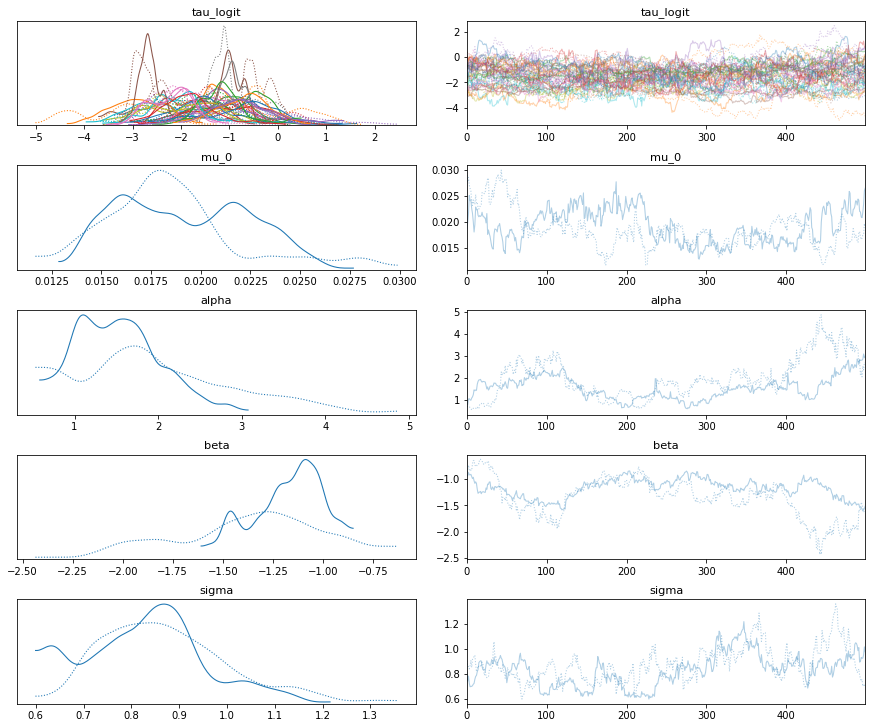

In [7]:
# Visualize the trace of the MCMC sampler to assess convergence
ax = pm.traceplot(trace)

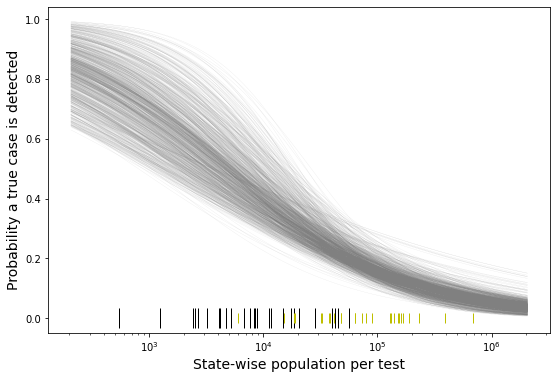

In [36]:
n = len(trace['beta'])

# South Korea:
ppt_sk = np.log10(51500000. / 250000)

x = np.linspace(0.0, 4.0, 101)
logit_pcase = pd.DataFrame([
    trace['alpha'][i] + trace['beta'][i] * x
    for i in range(n)])
pcase = np.exp(logit_pcase) / (np.exp(logit_pcase) + 1)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for i in range(n):
    ax = plt.plot(10**(ppt_sk + x), pcase.iloc[i], color='grey', lw=.1, alpha=.5)
    plt.xscale('log')
    plt.xlabel('State-wise population per test', size=14)
    plt.ylabel('Probability a true case is detected', size=14)

ax=plt.plot(df['people_per_test'], np.zeros(len(df)), marker='|', color='k', ls='', ms=20)
ax=plt.plot(df['people_per_test_7_days_ago'], np.zeros(len(df)), marker='|', color='y', ls='', ms=10)

In [57]:
# Compute predicted case counts per state right now
logit_now = pd.DataFrame([
    (trace['alpha'][i] + trace['beta'][i] * (np.log10(df['people_per_test']) - ppt_sk))
    for i in range(len(trace['beta']))])
prob_missing_now = np.exp(logit_now) / (np.exp(logit_now) + 1) 

predicted_counts_now = np.round(df['positive'] / prob_missing_now.mean(axis=0)).astype(int)


# Compute predicted case counts per state 7 days ago
logit_7d = pd.DataFrame([
    (trace['alpha'][i] + trace['beta'][i] * (np.log10(df['people_per_test_7_days_ago']) - ppt_sk))
    for i in range(len(trace['beta']))])
prob_missing_7d = np.exp(logit_7d) / (np.exp(logit_7d) + 1) 

predicted_counts_7d = np.round(df['num_pos_7_days_ago'] / prob_missing_7d.mean(axis=0)).astype(int)



death_rate_est = list(map(lambda x, y: 0.0 if y==0 else round(100. * x / float(y), 1), df['death'],
                          positive_cts_est_7daysago))
case_increase_percent = list(map(lambda x, y: int(100. * ((x - y) / float(y))),
                                 predicted_counts_now, df['positive']))
case_increase_percent_7days = list(map(lambda x, y: int(100. * ((x - y) / float(y))),
                                 predicted_counts_7d, df['num_pos_7_days_ago']))

df_summary = pd.DataFrame(
    data = {
     'positive_reported_to_date': df['positive'],
     'positive_estimated_to_date': predicted_counts_now,
     'case_increase_percent': case_increase_percent,
     'tests_per_million_today': df['tests_per_million'].round(1),
     'positive_reported_7days': df['num_pos_7_days_ago'],
     'positive_estimated_7days': predicted_counts_7d,
     'case_increase_percent_7days': case_increase_percent_7days,
     'tests_per_million_7days': df['tests_per_million_7_days_ago'].round(1)
    },
    index=df.index)
df_summary.sort_values('tests_per_million_today', ascending=False)

,positive_reported_to_date,positive_estimated_to_date,case_increase_percent,tests_per_million_today,positive_obs_7days,positive_estimated_7days,case_increase_percent_7days,tests_per_million_7days
state,,,,,,,,
WA,1012,1339,32,1855.4,162.0,340,109,167.0
VT,10,15,50,809.3,1.0,3,200,65.7
MN,60,101,68,414.2,3.0,13,333,23.9
NH,26,44,69,396.4,4.0,15,275,30.9
NY,1700,2932,72,370.4,173.0,923,433,13.6
RI,21,38,80,310.6,3.0,9,200,52.9
OR,65,123,89,244.9,15.0,45,200,54.1
DC,31,59,90,239.5,5.0,19,280,31.2
CA,483,949,96,214.2,133.0,590,343,20.8


In [62]:
from datetime import datetime
print("Total for the United States on %s:" % str(datetime.today())[:10])
print("Reported Case Count: %i" % df_summary['positive_reported_to_date'].sum())
print("Predicted Case Count: %i" % df_summary['positive_estimated_to_date'].sum())
case_increase_percent = 100. * (df_summary['positive_estimated_to_date'].sum() - df_summary['positive_reported_to_date'].sum()) / df_summary['positive_estimated_to_date'].sum()
print("Percentage Underreporting in Case Count: %.1f%%" % case_increase_percent)


Total for the United States on 2020-03-17:
Reported Case Count: 4938
Predicted Case Count: 9899
Percentage Underreporting in Case Count: 50.1%


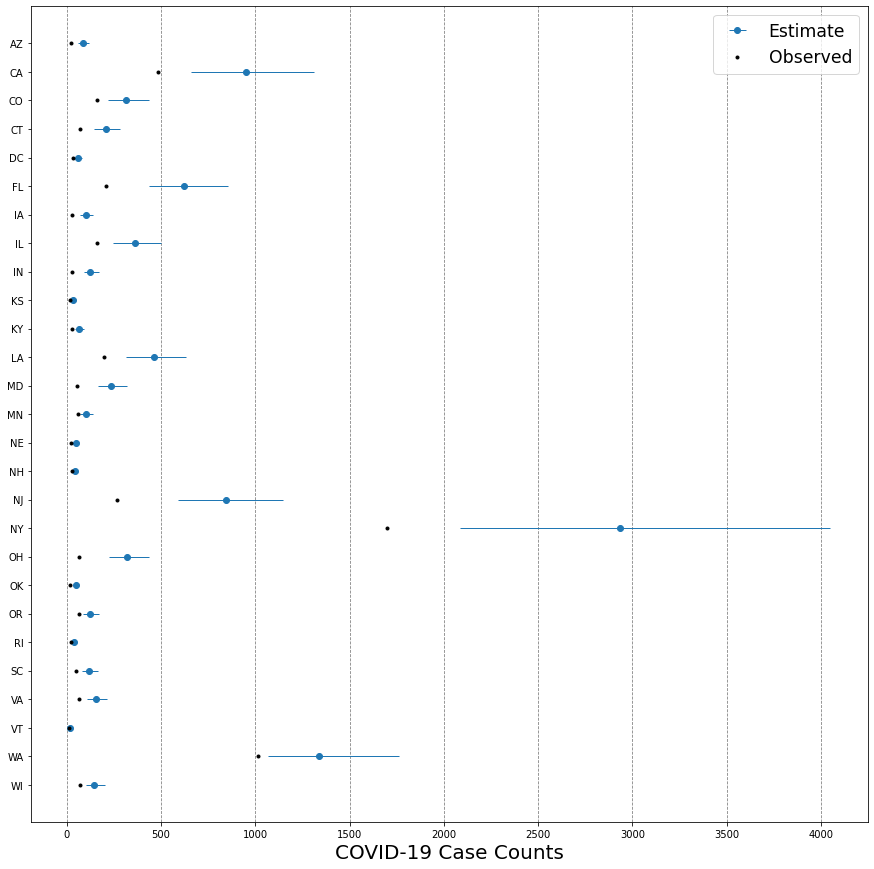

In [76]:
predicted_counts_now_lower = np.round(df_summary['positive_reported_to_date'] / prob_missing_now.quantile(0.975, axis=0)).astype(int)
predicted_counts_now_upper = np.round(df_summary['positive_reported_to_date'] / prob_missing_now.quantile(0.025, axis=0)).astype(int)
xerr = [df_summary['positive_estimated_to_date'] - predicted_counts_now_lower, predicted_counts_now_upper - df_summary['positive_estimated_to_date']]


fig, axs = plt.subplots(1, 1, figsize=(15, 15))
ax = plt.errorbar(df_summary['positive_estimated_to_date'], range(len(df_summary)-1, -1, -1), xerr=xerr,
                  fmt='o', elinewidth=1, label='Estimate')
ax = plt.yticks(range(len(df_summary)), df.index[::-1])
ax = plt.errorbar(df_summary['positive_reported_to_date'], range(len(df_summary)-1, -1, -1), xerr=None,
                  fmt='.', color='k', label='Observed')
ax = plt.xlabel('COVID-19 Case Counts', size=20)
ax = plt.legend(fontsize='xx-large')
ax = plt.grid(linestyle='--', color='grey', axis='x')

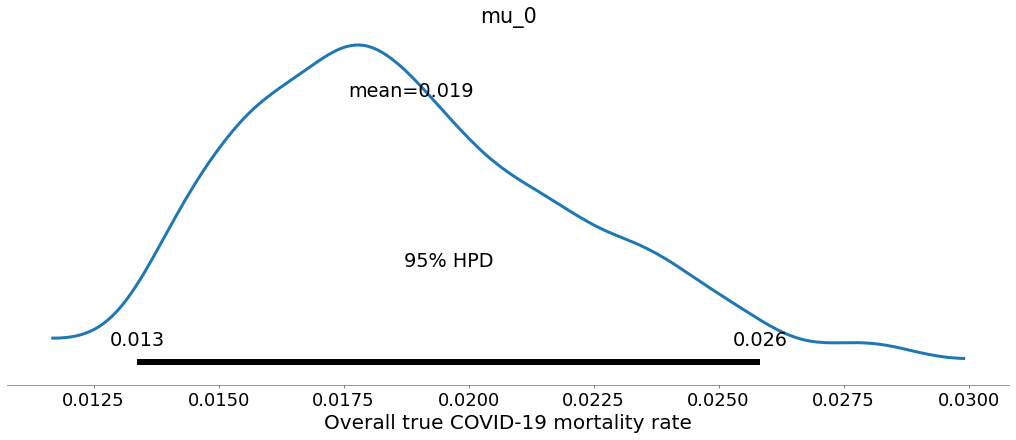

In [16]:
# Posterior plot for mu0
ax = pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                       credible_interval=0.95, bw=5.0, lw=3, kind='kde')
ax = plt.xlabel('Overall true COVID-19 mortality rate', size=20)